In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

This notebook created the data shown in the NAG poster [Nearest Correlation Matrices in the NAG Library](https://www.nag.com/market/posters/nearest-correlation-algos-nag-library.pdf)

In [2]:
from numpy import genfromtxt,floor,ceil,transpose,nan,zeros,isnan,mean,sum,diag,sqrt,eye,ones
from naginterfaces.library.correg import corrmat_nearest,corrmat_target,corrmat_fixed,corrmat_nearest_bounded
from naginterfaces.library.correg import corrmat_h_weight,corrmat_shrinking,corrmat_nearest_rank
from naginterfaces.base.utils import NagValueError
from numpy.random import rand,seed
from numpy.linalg import eig,norm
import matplotlib.pyplot as plt
import matplotlib
from pytictoc import TicToc
import numpy as np
import pandas as pd
import timeit
import warnings

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

def cor_bar(P):
    """
    cor_bar  Calculates approximate sample correlation matrix.

       S=COR_BAR(P)

       Produces an n-by-n approx correlation matrix based on
       data of size m-by-n. n columns of different
       random variables observed at m different times.
       P has missing data represented by NaNs.

       INPUT:  P  data matrix

       OUTPUT: R  approx sample correlation matrix
    """
    (m,n) = P.shape
    S = cov_bar(P)
    D = diag(1./sqrt(diag(S)))

    R = D@S@D
    return(R)

def cov_bar(P):
    """
    cov_bar  Calculates approximate sample covariance matrix.
    
       S = cov_bar(P)
    
       Produces an n-by-n approx covariance matrix based on
       data of size m-by-n. n columns of different
       random variables observed at m different times.
       P has missing data represented by NaNs.
    
       INPUT:  P  data matrix
    
       OUTPUT: S  approx sample covariance matrix
    """

    (m,n) = P.shape

    S = zeros((n,n));

    for i in range(n):
        xi = P[:,i]

        for j  in range(i+1):
            xj = P[:,j]

            # create mask for data values that are 'common'
            p = ~isnan(xi) & ~isnan(xj)

            S[i,j] = transpose((xi[p] - mean(xi[p]))) @ ( xj[p] - mean(xj[p]))

            # normalise over effective sample size i.e. sum(p)-1
            S[i,j] = 1.0/(sum(p)-1)*S[i,j]
            S[j,i] = S[i,j];

    return(S)

def plot_matdiff(x,g,maxdiff,xlabel,funcname,filename=False):
    # Plot the difference between G and X as a small shaded square for each element
    fig1, ax1 = plt.subplots(figsize=(14, 7))
    cax1 = ax1.imshow(abs(x - g), interpolation='none', cmap=plt.cm.Blues, 
                      vmin=0, vmax=0.2)
    cbar = fig1.colorbar(cax1, ticks = np.linspace(0.0, maxdiff, 11, endpoint=True), 
                         boundaries=np.linspace(0.0, maxdiff, 11, endpoint=True))
    cbar.set_clim([0, maxdiff])
    ax1.tick_params(axis='both', which='both', 
                    bottom='off', top='off', left='off', right='off', 
                    labelbottom='off', labelleft='off')
    ax1.set_title(r'$|G-X|$ for {0}'.format(funcname))
    plt.xlabel(xlabel)
    if filename:
        plt.savefig(filename)
    plt.show()

def gen_all_ncm_data(file,percent=0.1,n=6,random_seed=2,verbose=False):
    """
    Generates random data to benchmark NCM routines
    Firstly a fixed block case G = [A B; B^Y C] where 
    A should be preserved. (Tests TWO and THREE) 
    We also use this matrix to benchmark without 
    weighting or fixing. (ONE)
    Next we fix or weight C also. (FOUR and FIVE)
    THREE and FIVE also set a minimum eigenvalue.
    
    file - Filename of input data. Should be a .csv
    percent (Default=0.1) - Fraction of observations removed  #TODO - CHANGE TO MORE DESCRIPTIVE VARIABLE
    n (Default = 6) - Size of NCM matrix to consider = n x n
    """
    seed(random_seed)
    full_data = genfromtxt(file, delimiter=',')
    #The first column contains NaNs where the row titles were so we need to remove these.
    full_data = full_data[:,1:]
    
    # Extract just the first n rows from the full data set
    data = full_data[:n,:]
    (n,obvs) = data.shape
    
    # size of fixed block
    k = int(floor(n/2))
    # number of missing values
    missing = percent * obvs * (n-k)
    
    if verbose:
        print('Test matrix size is {0}x{0}'.format(n))
    
    # 1 Fixed block  
    data1 = transpose(data.copy())
   
    # remove "missing" elements from k+1:n variables
    elements = obvs * (n-k)
    for j in range(int(missing)):
        pos = ceil(rand()*elements)
        data1[int(pos % obvs),int(k+ceil(pos/obvs)-1)] = nan
        
    # Construct approx correlation matrix
    g1 = cor_bar(data1)
    
    if verbose:
        #Find minium eigenvalue of g1, should be negative
        #If it isn't negative then it is already a valid correlation matrix and we have nothing to do
        (vals,vecs) = eig( g1[:n,:n] )
        eig_n = min( vals )
        print('Smallest Eigenvalue of g1 should be negative and it is {0}'.format(eig_n))
              
    # 2 Fixed Blocks
    data2 = transpose(data.copy())
    
    # Rove rows to keep diagonal blocks good, but off diagonal bad 
    num_rows = int(ceil(percent*obvs))
    data2[:num_rows,:k] = nan
    data2[obvs-num_rows:obvs,k:n] = nan
     
    g2 = cor_bar(data2)
    
    return(g1,g2)


def test_corrmat_nearest(g,num_repeats,plot=True,usemaxscale=False,setmaxscale=0.001,plotfilename=False,verbose=True):
    t = TicToc()    
    t.tic()
    for repeat in range(num_repeats):
        (X_g02aa, itera, feval, nrmgrd) = corrmat_nearest(g)
    time = t.tocvalue() / num_repeats
    res = norm( X_g02aa-g, 'fro' )
    if verbose:
        print('corrmat_nearest (g02aa) time={0} its={1}, norm={2}'.format(time, itera, res))
    if plot:
        maxscale = setmaxscale
        if usemaxscale:
                maxscale = np.max(abs(X_g02aa - g)) 
        xlabel = "Iterations: {0}, $||G-X||_F = {1:.4f}$".format(itera,norm(X_g02aa - g))
        plot_matdiff(X_g02aa,g,maxscale,xlabel,'corrmat_nearest',plotfilename)
    return(time,res)

def test_corrmat_fixed(g,alpha,h,m,num_repeats,plot=True,usemaxscale=False,setmaxscale=0.001,plotfilename=False,verbose=True):
    h = h.astype(int)
    t = TicToc() 
    t.tic()
    for repeat in range(num_repeats):
        try:
            (X_g02as,itera,fnorm) = corrmat_fixed(g,alpha,h,m,errtol=0.0, maxit=100)
            time = t.tocvalue() / num_repeats
        except NagValueError:
            print('corrmat_fixed failed to converge. Returning nan as the time.')
            time = nan
            return((time,nan))
    time = t.tocvalue() / num_repeats
    res = norm( X_g02as-g, 'fro' )
    if verbose:
        print('corrmat_fixed (g02as) time={0} its={1}, norm={2}'.format(time, itera, res))
    if plot:
        maxscale = setmaxscale
        if usemaxscale:
                maxscale = np.max(abs(X_g02as-g)) 
        xlabel = "Iterations: {0}, $||G-X||_F = {1:.4f}$".format(itera,norm(X_g02as - g))
        plot_matdiff(X_g02as,g,maxscale,xlabel,'corrmat_fixed',plotfilename)
    return(time,res)

def test_corrmat_h_weight(g,alpha,h,num_repeats,plot=True,usemaxscale=False,setmaxscale=0.001,plotfilename=False,verbose=True):
    t = TicToc()
    t.tic()
    for repeat in range(num_repeats):
        (X_g02aj,itera,norma) = corrmat_h_weight(g,alpha,h,maxit=int(500))
    time = t.tocvalue() / num_repeats
    res = norm( X_g02aj-g, 'fro' )
    if verbose:
        print('corrmat_h_weight (g02aj) time={0} its={1}, norm={2}'.format(time, itera, res))
    if plot:
        maxscale = setmaxscale
        if usemaxscale:
                maxscale = np.max(abs(X_g02aj-g)) 
        xlabel = "Iterations: {0}, $||G-X||_F = {1:.4f}$".format(itera,norm(X_g02aj - g))
        plot_matdiff(X_g02aj,g,maxscale,xlabel,'corrmat_h_weight',plotfilename)
    return(time,res)

def test_corrmat_target(g, theta, h,num_repeats,plot=True,usemaxscale=False,setmaxscale=0.001,plotfilename=False,verbose=True):
    t = TicToc()
    
    t.tic()
    for repeat in range(num_repeats):
        (h,X_g02ap,alpha,itera,eigmin,norma) = corrmat_target(g, theta, h, errtol=0.0, eigtol=0.0)
    time = t.tocvalue() / num_repeats
    res = norm( X_g02ap-g, 'fro' )
    if verbose:
        print('corrmat_target (g02ap) time={0} its={1}, norm={2}'.format(time, itera, res))
    if plot:
        maxscale = setmaxscale
        if usemaxscale:
                maxscale = np.max(abs(X_g02ap-g)) 
        xlabel = "Iterations: {0}, $||G-X||_F = {1:.4f}$".format(itera,norm(X_g02ap - g))
        plot_matdiff(X_g02ap,g,maxscale,xlabel,'corrmat_target',plotfilename)
    return(time,res)

def test_corrmat_nearest_bounded(g,opt,alpha,w,num_repeats,plot=True,usemaxscale=False,setmaxscale=0.001,plotfilename=False,verbose=True):
    t = TicToc()
    
    t.tic()
    for repeat in range(num_repeats):
        (X_g02ab,itera,feval,nrmgrd) = corrmat_nearest_bounded(g,opt,alpha,w)
    time = t.tocvalue() / num_repeats
    res = norm( X_g02ab-g, 'fro' )
    if verbose:
        print('corrmatt_nearest_bounded (g02ab) time={0} its={1}, norm={2}'.format(time, itera, res))
    if plot:
        maxscale = setmaxscale
        if usemaxscale:
                maxscale = np.max(abs(X_g02ab-g))  
        xlabel = "Iterations: {0}, $||G-X||_F = {1:.4f}$".format(itera,res)
        plot_matdiff(X_g02ab,g,maxscale,xlabel,'corrmat_nearest_bounded',plotfilename)
    return(time,res)
        
def test_corrmat_shrinking(g,k,num_repeats,plot=True,usemaxscale=False,setmaxscale=0.001,plotfilename=False,verbose=True): 
    t = TicToc()
    
    t.tic()
    for repeat in range(num_repeats):
        (X_g02an,alpha_out,itera,eigmin,norma) = corrmat_shrinking(g,k)
    time = t.tocvalue() / num_repeats
    res = norm( X_g02an-g, 'fro' )
    if verbose:
        print('corrmat_shrinking (g02an) time={0} its={1}, norm={2}'.format(time, itera, res))
    if plot:
        maxscale = setmaxscale
        if usemaxscale:
                maxscale = np.max(abs(X_g02an-g)) 
        xlabel = "Iterations: {0}, $||G-X||_F = {1:.4f}$".format(itera,res)
        plot_matdiff(X_g02an,g,maxscale,xlabel,'corrmat_shrinking',plotfilename)
    return(time,res)

def test1(g,repeats=10,plot=True,verbose=True):
    """
Computes the nearest correlation matrix, all elements in the original matrix are free to move.
    """
    (n,m) = g.shape
    if verbose:
        print('Test 1 - size={0}'.format(n))
        print(test1.__doc__)
    alpha = 0.0
    theta = 0.0
    h = eye(n)
    
    (nearest_time,nearest_res) = test_corrmat_nearest(g,num_repeats = repeats,plot=plot,setmaxscale=0.001,plotfilename="test1_corrmat_nearest.png",verbose=verbose)
    (fixed_time,fixed_res) = test_corrmat_fixed(g,alpha,h,m=4,num_repeats = repeats,plot=plot,usemaxscale=True,plotfilename="test1_corrmat_fixed.png",verbose=verbose)
    (target_time,target_res) = test_corrmat_target(g,theta, h, num_repeats = repeats,plot=plot,usemaxscale=True,plotfilename="test1_corrmat_target.png",verbose=verbose)  
    
    results = pd.DataFrame(np.array([[n,nearest_time,fixed_time,target_time]]))
    results.columns=["MatSize","corrmat_nearest","corrmat_fixed","corrmat_target"]
    results = results.set_index('MatSize')
    
    norms = pd.DataFrame(np.array([[n,nearest_res,fixed_res,target_res]]))
    norms.columns=["MatSize","corrmat_nearest","corrmat_fixed","corrmat_target"]
    norms = norms.set_index('MatSize')
    
    return(results,norms)
          
def test2(g,repeats=10,plot=True,verbose=True):
    """
Computes the nearest correlation matrix, preserving, if possible, an upper left block of the original matrix.
    """
    # Test 2
    (n,m) = g.shape
    if verbose:
        print('\nTest 2 - size={0}'.format(n))
        print(test2.__doc__)
    t = TicToc()
    
    h = eye(n)
    k = int(floor(n/2)) # size of fixed block
    h[:k,:k] = ones((k,k))
    w = ones(n)
    w[:k] = 10
    theta = 0.0
    alpha = 0.0
    opt = 'W'
    
    (nearest_bounded_time,nearest_bounded_res) = test_corrmat_nearest_bounded(g,opt,alpha,w, num_repeats = repeats,plot=plot,usemaxscale=True,plotfilename="test2_corrmat_nearest_bounded.png",verbose=verbose)
    (h_weight_time,h_weight_res) = test_corrmat_h_weight(g,alpha,h,num_repeats = repeats,plot=plot,usemaxscale=True,plotfilename="test2_corrmat_h_weight.png",verbose=verbose)
    (shrinking_time,shrinking_res) = test_corrmat_shrinking(g,k,num_repeats = repeats,plot=plot,usemaxscale=True,plotfilename="test2_corrmat_shrinking.png",verbose=verbose)
    (fixed_time,fixed_res) = test_corrmat_fixed(g,alpha,h,m=4,num_repeats = repeats,plot=plot,usemaxscale=True,plotfilename="test2_corrmat_fixed.png",verbose=verbose)    
    
    results = pd.DataFrame(np.array([[n,nearest_bounded_time,h_weight_time,shrinking_time,fixed_time]]))
    results.columns=["MatSize","corrmat_nearest_bounded","corrmat_h_weight","corrmat_shrinking","corrmat_fixed"]
    results = results.set_index('MatSize')
    
    norms = pd.DataFrame(np.array([[n,nearest_bounded_res,h_weight_res,shrinking_res,fixed_res]]))
    norms.columns=["MatSize","corrmat_nearest_bounded","corrmat_h_weight","corrmat_shrinking","corrmat_fixed"]
    norms = norms.set_index('MatSize')
    
    return(results,norms)
    
def test3(g,repeats=10,plot=True,verbose=True):
    """
Computes the nearest correlation matrix, preserving, if possible, an upper left block of the original matrix and specifying a minimum eigenvalue for the result.
    """
    (n,m) = g.shape
    if verbose:
        print('\nTest 3 - size={0}'.format(n))
        print(test3.__doc__)
    t = TicToc()
    
    h = eye(n)
    k = int(floor(n/2)) # size of fixed block
    h[:k,:k] = ones((k,k))
    w = ones(n)
    w[:k] = 10
    
    # Find minium eigenvalue of fixed block, should be positive
    (b1_vals,b1_vecs) = eig( g[:k,:k] )
    eig_b1 = min( b1_vals )
    
    alpha = 0.001
    theta = alpha/eig_b1
    opt='B'
    
    (nearest_bounded_time,nearest_bounded_res) = test_corrmat_nearest_bounded(g,opt,alpha,w,num_repeats = repeats,plot=plot,usemaxscale=True,plotfilename="test3_corrmat_nearest_bounded.png",verbose=verbose)
    (h_weight_time,h_weight_res) = test_corrmat_h_weight(g,alpha,h,num_repeats = repeats,plot=plot,usemaxscale=True,plotfilename="test3_corrmat_h_weight.png",verbose=verbose)
    (shrinking_time,shrinking_res)= test_corrmat_shrinking(g,k,num_repeats = repeats,plot=plot,usemaxscale=True,plotfilename="test3_corrmat_shrinking.png",verbose=verbose)
    (fixed_time,fixed_res) = test_corrmat_fixed(g,alpha,h,m=4,num_repeats = repeats,plot=plot,usemaxscale=True,plotfilename="test3_corrmat_fixed.png",verbose=verbose)  
    
    results = pd.DataFrame(np.array([[n,nearest_bounded_time,h_weight_time,shrinking_time,fixed_time]]))
    results.columns=["MatSize","corrmat_nearest_bounded","corrmat_h_weight","corrmat_shrinking","corrmat_fixed"]
    results = results.set_index('MatSize')
    
    norms = pd.DataFrame(np.array([[n,nearest_bounded_res,h_weight_res,shrinking_res,fixed_res]]))
    norms.columns=["MatSize","corrmat_nearest_bounded","corrmat_h_weight","corrmat_shrinking","corrmat_fixed"]
    norms = norms.set_index('MatSize')
    
    return(results,norms)

def test4(g,repeats=10,plot = True,verbose=True):
    """
    Test 4: Computes the nearest correlation matrix, preserving, if possible, the diagonal blocks of a 2x2 partitioned original matrix.
    """
    (n,m) = g.shape
    if verbose:
        print('\nTest 4 - size={0}'.format(n))
        print(test4.__doc__)
    t = TicToc()
    
    k = int(floor(n/2)) # size of fixed block
    
    h = eye(n);
    h[:k,:k] = ones((k,k))
    h[k:n,k:n] = ones((n-k,n-k))
    
    alpha = 0.0
    theta = 0.0
    
    (h_weight_time,h_weight_res) = test_corrmat_h_weight(g,alpha,h,num_repeats = repeats,plot=plot,usemaxscale=True,plotfilename="test4_corrmat_h_weight.png",verbose=verbose)
    (target_time,target_res) = test_corrmat_target(g,theta, h, num_repeats = repeats,plot=plot,usemaxscale=True,plotfilename="test4_corrmat_target.png",verbose=verbose)
    (fixed_time,fixed_res) = test_corrmat_fixed(g,alpha,h,m=4,num_repeats = repeats,plot=plot,usemaxscale=True,plotfilename="test4_corrmat_fixed.png",verbose=verbose)
    
    results = pd.DataFrame(np.array([[n,h_weight_time,target_time,fixed_time]]))
    results.columns=["MatSize","corrmat_h_weight","corrmat_target","corrmat_fixed"]
    results = results.set_index('MatSize')

def test5(g,repeats=10,verbose=True):
    """
    Test 5: Computes the nearest correlation matrix, preserving, if possible, the diagonal blocks of a 2x2 partitioned original matrix and specifying a minimum eigenvalue for the result.
    """
    
    (n,m) = g.shape
    if verbose:
        print('\nTest 5 - size={0}'.format(n))
        print(test5.__doc__)
    t = TicToc()
    
    k = int(floor(n/2)) # size of fixed block
    
    h = eye(n);
    h[:k,:k] = ones((k,k))
    h[k:n,k:n] = ones((n-k,n-k))
     
    # Find minium eigenvalue of fixed blocks, should be positive
    (b1_vals,b1_vecs) = eig( g[:k,:k] )
    eig_b1 = min( b1_vals )
    (b2_vals,b2_vecs) = eig( g[k:n,k:n] )
    eig_b2 = min( b2_vals )
    
    alpha = 0.001
    eigmin = min( eig_b1, eig_b2 );
    theta = alpha/eigmin;
    opt='B'
    if verbose:   
        print("minimum eigenvalue of the 2 fixed blocks is {0}\n".format(eigmin))
    
    test_corrmat_h_weight(g,alpha,h,num_repeats = repeats,plot=True,usemaxscale=True,plotfilename="test5_corrmat_h_weight.png",verbose=verbose)
    test_corrmat_target(g,theta, h, num_repeats = repeats,plot=True,usemaxscale=True,plotfilename="test5_corrmat_target.png",verbose=verbose)
    test_corrmat_fixed(g,alpha,h,m=4,num_repeats = repeats,plot=True,usemaxscale=True,plotfilename="test5_corrmat_fixed.png",verbose=verbose)

# Generate broken correlation matrix

We generate a broken correlation matrix by loading real stock data and removing a certain percentage of it.  Here, 10 percent of the data is thrown away

In [3]:
(g1,g2) = gen_all_ncm_data('data_sp600_06yr.csv',n=200,random_seed=3,percent=0.1,verbose=True)

Test matrix size is 200x200
Smallest Eigenvalue of g1 should be negative and it is -0.04519164765962588


# Test 1

Test 1 - size=200

Computes the nearest correlation matrix, all elements in the original matrix are free to move.
    
corrmat_nearest (g02aa) time=0.01880222119999999 its=4, norm=0.19848365625578968


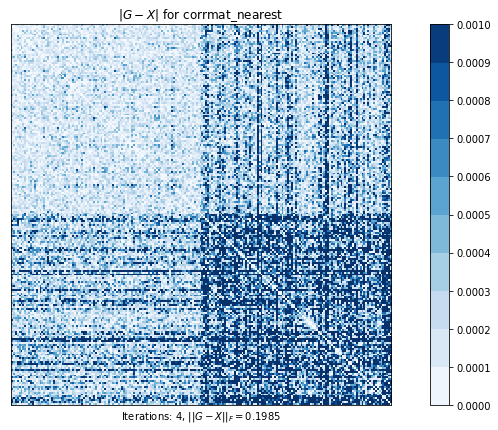

corrmat_fixed (g02as) time=0.12233972249999994 its=32, norm=0.19848383334382902


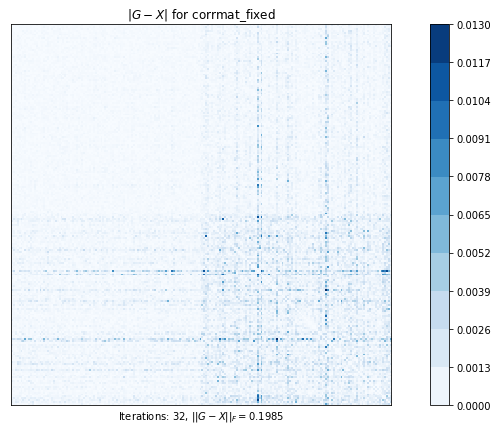

corrmat_target (g02ap) time=0.004642809799999981 its=27, norm=4.974169487825003


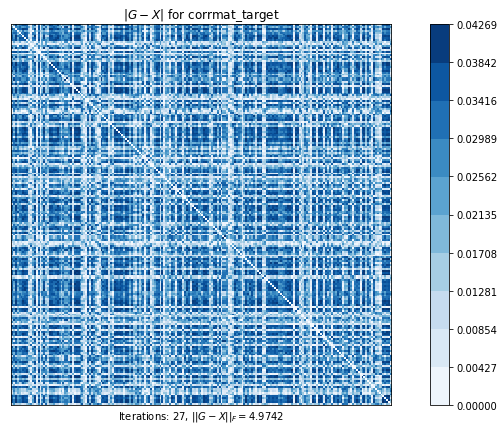

(         corrmat_nearest  corrmat_fixed  corrmat_target
 MatSize                                                
 200.0           0.018802        0.12234        0.004643,
          corrmat_nearest  corrmat_fixed  corrmat_target
 MatSize                                                
 200.0           0.198484       0.198484        4.974169)

In [4]:
#Computes the nearest correlation matrix, all elements in the original matrix are free to move.
#The plot shows the difference between the original matrix and the computed Nearest Correlation Matrix
#The darker the pixel, the greater the difference
test1(g1)

# Test 2


Test 2 - size=200

Computes the nearest correlation matrix, preserving, if possible, an upper left block of the original matrix.
    
corrmatt_nearest_bounded (g02ab) time=0.023739818800000024 its=6, norm=0.2741223031394272


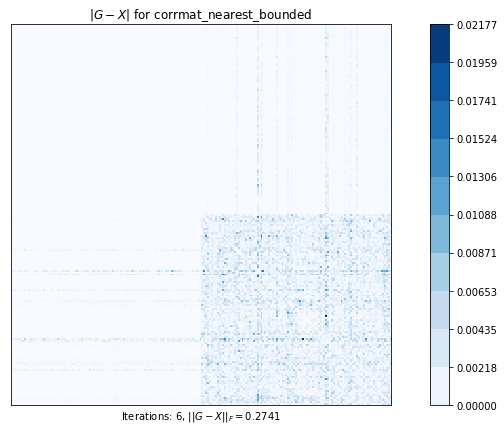

corrmat_h_weight (g02aj) time=0.32874805880000013 its=143, norm=0.2026134982193631


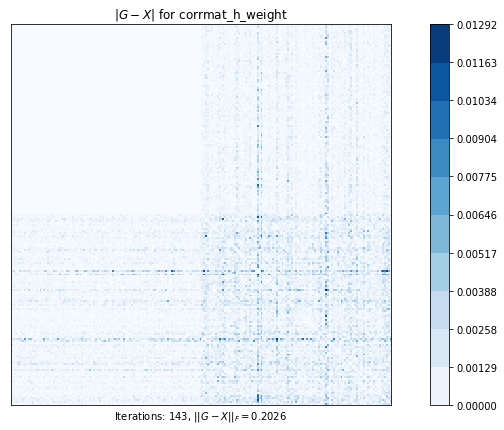

corrmat_shrinking (g02an) time=0.003360725599999981 its=27, norm=4.749647387489478


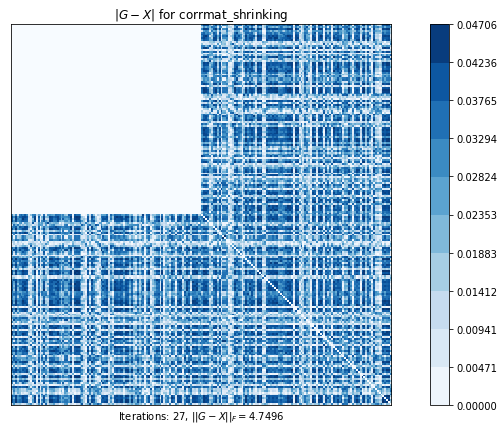

corrmat_fixed (g02as) time=0.12284260710000013 its=32, norm=0.20008340363845287


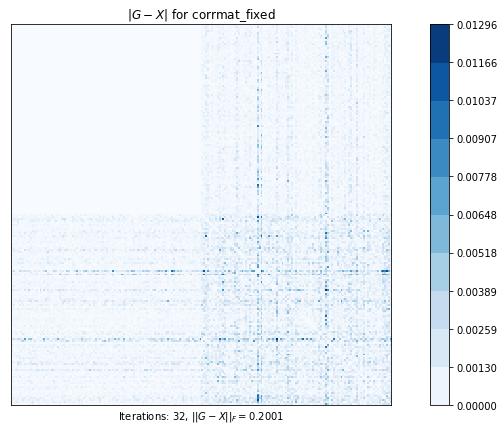

(         corrmat_nearest_bounded  corrmat_h_weight  corrmat_shrinking  \
 MatSize                                                                 
 200.0                    0.02374          0.328748           0.003361   
 
          corrmat_fixed  
 MatSize                 
 200.0         0.122843  ,
          corrmat_nearest_bounded  corrmat_h_weight  corrmat_shrinking  \
 MatSize                                                                 
 200.0                   0.274122          0.202613           4.749647   
 
          corrmat_fixed  
 MatSize                 
 200.0         0.200083  )

In [5]:
# Computes the nearest correlation matrix, preserving, if possible, an upper left block of the original matrix.
test2(g1)

# Test 3


Test 3 - size=200

Computes the nearest correlation matrix, preserving, if possible, an upper left block of the original matrix and specifying a minimum eigenvalue for the result.
    
corrmatt_nearest_bounded (g02ab) time=0.0249553333999998 its=6, norm=0.29188823015833215


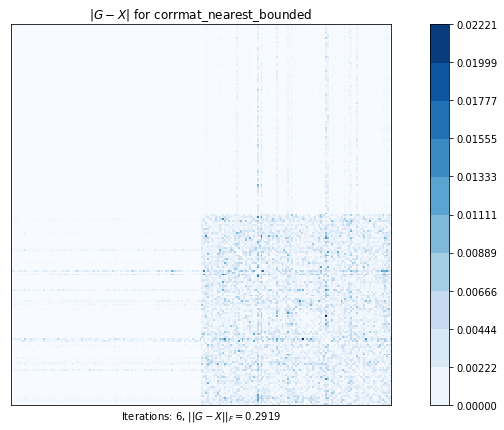

corrmat_h_weight (g02aj) time=0.42672047189999984 its=144, norm=0.21394785831325455


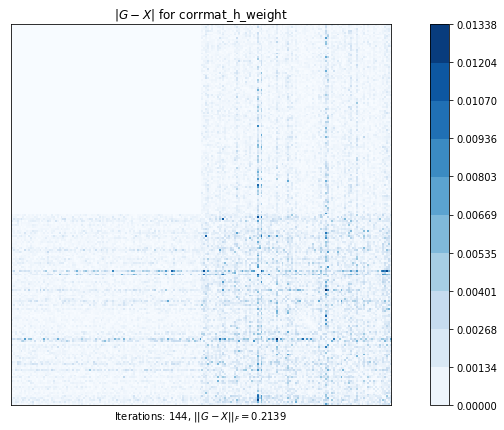

corrmat_shrinking (g02an) time=0.00232538059999996 its=27, norm=4.749647387489478


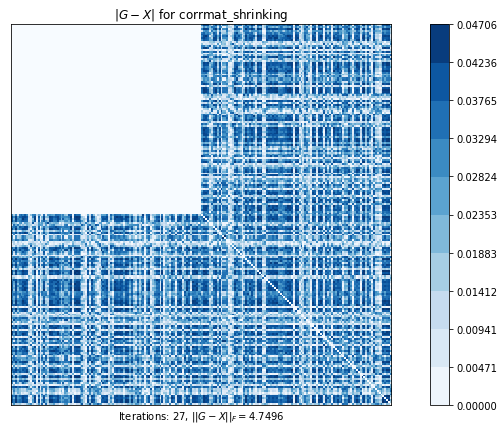

corrmat_fixed (g02as) time=0.14476502070000025 its=40, norm=0.2112270891810479


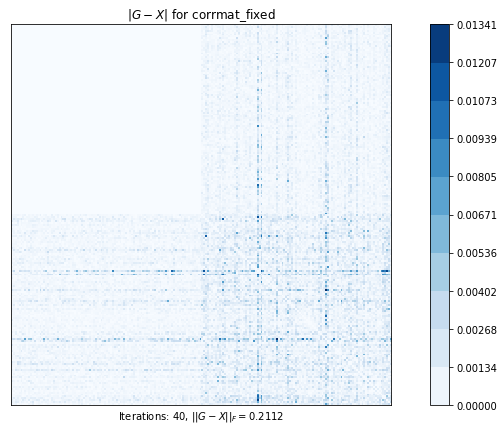

(         corrmat_nearest_bounded  corrmat_h_weight  corrmat_shrinking  \
 MatSize                                                                 
 200.0                   0.024955           0.42672           0.002325   
 
          corrmat_fixed  
 MatSize                 
 200.0         0.144765  ,
          corrmat_nearest_bounded  corrmat_h_weight  corrmat_shrinking  \
 MatSize                                                                 
 200.0                   0.291888          0.213948           4.749647   
 
          corrmat_fixed  
 MatSize                 
 200.0         0.211227  )

In [6]:
#Computes the nearest correlation matrix, preserving, if possible, 
# an upper left block of the original matrix and specifying a minimum eigenvalue for the result.
#The plot shows the difference between the original matrix and the computed Nearest Correlation Matrix
#The darker the pixel, the greater the difference
test3(g1)

# Test 4


Test 4 - size=200

    Test 4: Computes the nearest correlation matrix, preserving, if possible, the diagonal blocks of a 2x2 partitioned original matrix.
    
corrmat_h_weight (g02aj) time=0.5691674330999998 its=210, norm=4.2415769479815095


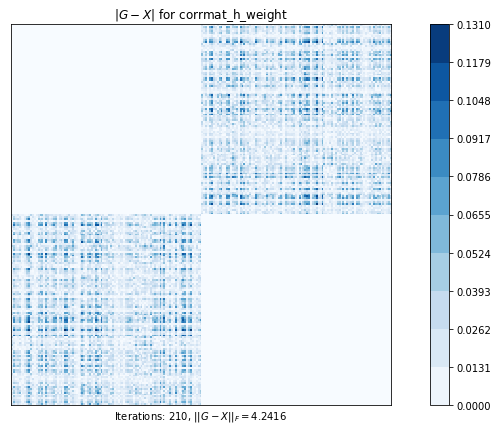

corrmat_target (g02ap) time=0.005968094099999632 its=27, norm=8.216919543483945


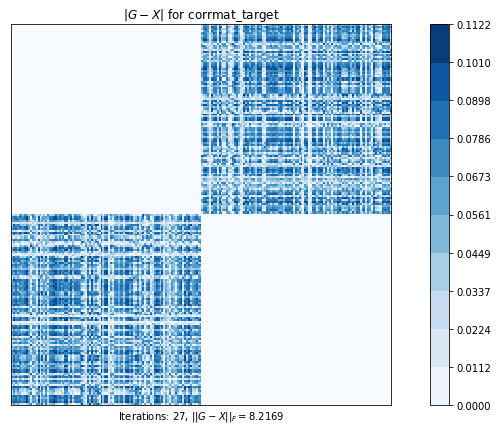

corrmat_fixed (g02as) time=0.09307719119999973 its=25, norm=4.207809588867262


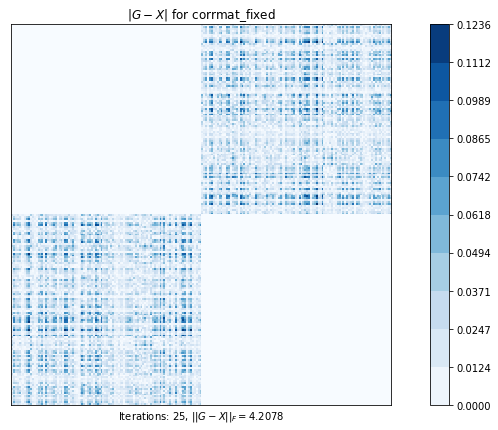

In [7]:
#Computes the nearest correlation matrix, preserving, if possible, the diagonal blocks of a 2x2 partitioned original matrix.
#The plot shows the difference between the original matrix and the computed Nearest Correlation Matrix
#The darker the pixel, the greater the difference

test4(g2)

# Test 5


Test 5 - size=200

    Test 5: Computes the nearest correlation matrix, preserving, if possible, the diagonal blocks of a 2x2 partitioned original matrix and specifying a minimum eigenvalue for the result.
    
minimum eigenvalue of the 2 fixed blocks is 0.0009119866783221636

corrmat_h_weight (g02aj) time=1.1305440822000001 its=198, norm=4.247239921631062


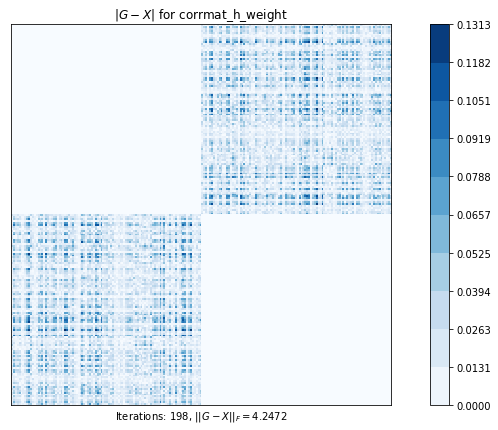

NagValueError: (NAG Python function naginterfaces.base.correg.corrmat_target, code 3:3,1003)
** On entry, theta = 0.109650724486432E+01.
** Constraint: theta < 1.0.

In [8]:
#Computes the nearest correlation matrix, preserving, if possible, the diagonal blocks of a 2x2 partitioned original matrix and specifying a minimum eigenvalue for the result.
#The plot shows the difference between the original matrix and the computed Nearest Correlation Matrix
#The darker the pixel, the greater the difference
test5(g2)

# Scaling test 1

We now see how solution time varies with matrix size for the various solver routines

In [14]:
sizes = range(50,501,50)
times = pd.DataFrame()
norms = pd.DataFrame()
for size in sizes: 
    (g1,g2) = gen_all_ncm_data('data_sp600_06yr.csv',n=size,random_seed=3,percent=0.1,verbose=False)
    (time,thisnorm) = test1(g1,repeats=10,plot=False,verbose=False)
    times = pd.concat([times,time])
    norms = pd.concat([norms,thisnorm])
times.to_csv('test1_times.csv')
norms.to_csv('test1_norms.csv')
times

,corrmat_nearest,corrmat_fixed,corrmat_target
MatSize,,,
50.0,0.001507,0.004228,0.000743
100.0,0.005066,0.017035,0.001638
150.0,0.010110,0.058214,0.003499
200.0,0.016392,0.159881,0.003662
250.0,0.024968,0.326784,0.006156
300.0,0.035980,0.340655,0.007679
350.0,0.060690,0.792486,0.010839
400.0,0.076551,1.332434,0.012364
450.0,0.082097,1.240161,0.017019


In [15]:
norms

,corrmat_nearest,corrmat_fixed,corrmat_target
MatSize,,,
50.0,0.036431,0.036431,0.586536
100.0,0.057950,0.057950,1.265381
150.0,0.141608,0.141608,3.535194
200.0,0.198484,0.198484,4.974169
250.0,0.273451,0.273450,6.594377
300.0,0.299582,0.299582,8.392438
350.0,0.427399,0.427395,11.684947
400.0,0.461658,0.461653,13.615143
450.0,0.527523,0.527520,15.834235


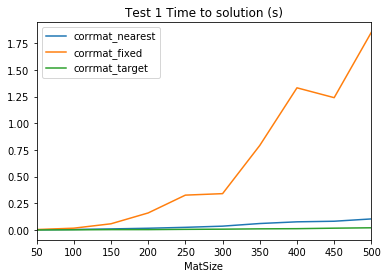

In [16]:
# Load from file and plot
test1_results = pd.read_csv('test1_times.csv',index_col=0)
test1_results.plot()
plt.title('Test 1 Time to solution (s)')
plt.savefig('test1_scaling.png')

# Scaling Test 2

In [17]:
sizes = range(50,501,50)
times2 = pd.DataFrame()
norms2 = pd.DataFrame()
for size in sizes: 
    (g1,g2) = gen_all_ncm_data('data_sp600_06yr.csv',n=size,random_seed=3,percent=0.1,verbose=False)
    (time,thisnorm) = test2(g1,repeats=10,plot=False,verbose=False)
    times2 = pd.concat([times2,time])
    norms2 = pd.concat([norms2,thisnorm])
times2.to_csv('test2_times.csv')
norms2.to_csv('test2_norms.csv')
times2

,corrmat_nearest_bounded,corrmat_h_weight,corrmat_shrinking,corrmat_fixed
MatSize,,,,
50.0,0.002095,0.031946,0.000545,0.004413
100.0,0.005953,0.117579,0.000857,0.019222
150.0,0.014070,0.265287,0.001387,0.057748
200.0,0.021630,0.441480,0.002309,0.158402
250.0,0.035854,0.697917,0.003813,0.355081
300.0,0.050336,0.980578,0.005018,0.329038
350.0,0.067137,1.377873,0.005678,1.153101
400.0,0.086270,1.781721,0.006498,1.520508
450.0,0.114125,1.899170,0.008666,1.380511


In [18]:
norms2

,corrmat_nearest_bounded,corrmat_h_weight,corrmat_shrinking,corrmat_fixed
MatSize,,,,
50.0,0.061481,0.036964,0.538910,0.036601
100.0,0.094640,0.059782,1.317656,0.058625
150.0,0.207350,0.144398,3.328873,0.142627
200.0,0.274122,0.202613,4.749647,0.200083
250.0,0.363962,0.279006,6.315969,0.275650
300.0,0.412061,0.305694,8.303853,0.302068
350.0,0.544452,0.434568,11.497122,0.430317
400.0,0.592730,0.469202,13.413678,0.464864
450.0,0.673075,0.537169,16.048218,0.531557


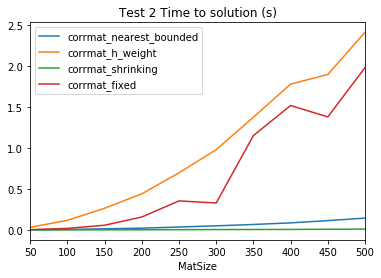

In [19]:
# Load from file and plot
test2_results = pd.read_csv('test2_times.csv',index_col=0)
test2_results.plot()
plt.title('Test 2 Time to solution (s)')
plt.savefig('test2_scaling.png')

# Scaling Test 3

In [22]:
sizes = range(50,501,50)
times3 = pd.DataFrame()
norms3 = pd.DataFrame()
for size in sizes: 
    (g1,g2) = gen_all_ncm_data('data_sp600_06yr.csv',n=size,random_seed=3,percent=0.10,verbose=False)
    (time,thisnorm) = test3(g1,repeats=10,plot=False,verbose=False)
    times3 = pd.concat([times3,time])
    norms3 = pd.concat([norms3,thisnorm])
times3.to_csv('test3_times.csv')
norms3.to_csv('test3_norms.csv')
times3

corrmat_fixed failed to converge. Returning nan as the time.
corrmat_fixed failed to converge. Returning nan as the time.
corrmat_fixed failed to converge. Returning nan as the time.
corrmat_fixed failed to converge. Returning nan as the time.
corrmat_fixed failed to converge. Returning nan as the time.
corrmat_fixed failed to converge. Returning nan as the time.


,corrmat_nearest_bounded,corrmat_h_weight,corrmat_shrinking,corrmat_fixed
MatSize,,,,
50.0,0.002108,0.032379,0.000552,0.004937
100.0,0.005998,0.119652,0.000859,0.018615
150.0,0.014243,0.275873,0.001390,0.061095
200.0,0.021669,0.532417,0.002306,0.198863
250.0,0.035913,1.665548,0.003815,NaN
300.0,0.052591,3.065310,0.005082,NaN
350.0,0.068778,4.251140,0.005748,NaN
400.0,0.104276,5.194119,0.006569,NaN
450.0,0.112667,5.857296,0.008791,NaN


In [23]:
norms3

,corrmat_nearest_bounded,corrmat_h_weight,corrmat_shrinking,corrmat_fixed
MatSize,,,,
50.0,0.066512,0.039832,0.538910,0.039410
100.0,0.104984,0.064710,1.317656,0.063430
150.0,0.221349,0.152816,3.328873,0.150886
200.0,0.291888,0.213948,4.749647,0.211227
250.0,0.383613,0.294094,6.315969,NaN
300.0,0.431817,0.319817,8.303853,NaN
350.0,0.566489,0.453559,11.497122,NaN
400.0,0.615492,0.490537,13.413678,NaN
450.0,0.697933,0.561680,16.048218,NaN


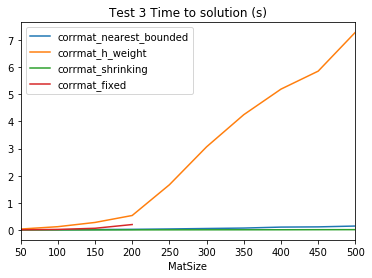

In [24]:
# Load from file and plot
test3_results = pd.read_csv('test3_times.csv',index_col=0)
test3_results.plot()
plt.title('Test 3 Time to solution (s)');
plt.savefig('test3_scaling.png')

# System information

The scaling results were run on an Amazon EC2 instance.  System details shown here

In [25]:
import multiprocessing
!date
!uname -r
!test -d /etc/redhat-release && cat /etc/redhat-release !test -d /etc/debian_version && cat /etc/debian_version !test -d /etc/os-release && cat /etc/os-release
print('CPUS available = {0}'.format(multiprocessing.cpu_count()))
!hostname
!cat /proc/cpuinfo | grep 'model name' | uniq

Tue May 21 09:37:21 UTC 2019
4.14.77-70.59.amzn1.x86_64
CPUS available = 16
ip-172-31-34-138
model name	: Intel(R) Xeon(R) CPU E5-2666 v3 @ 2.90GHz
